## GBM L2

Gradient Boosting 的前奏。选用简单的 MSE 来寻找残差的最佳划分。

这里有一个很好的解释，[GBM - MSE](http://explained.ai/gradient-boosting/L2-loss.html)

实现一个最常用的 GBM。它是通过不断优化 MSE, 即称了 L2 cost 来完成建模。L2 的缺点是对 outlier 点敏感。

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [193]:
def data():
    return pd.read_csv('rent.txt', delimiter='\t')

class DecisionTree(object):
    '''
        构建用于回归的决策树桩
    '''
    def __init__(self):
        return 
    
    def model(self, X, y):
        m, n = X.shape
        split_feature = 0
        split_val = 0
        lmean, rmean = 0, 0
        min_mse = np.inf
        for i in range(n):
            vals = list(set(X[:, i]))
            vals.sort()
            candidates = [(vals[i] + vals[i + 1]) / 2 for i in range(len(vals) - 1)]
            for c in candidates:
                xVals = X[:, i]
                mse = np.var(y[xVals <= c]) + np.var(y[xVals > c])
                if mse <= min_mse:
                    min_mse, split_feature, split_val = mse, i, c
                    lmean, rmean = round(np.mean(y[xVals <= c]), 2), round(np.mean(y[xVals > c]), 2)
                    
        self.split_feature = split_feature
        self.split_val = split_val
        self.lmean, self.rmean = lmean, rmean
        return self

    def predict(self, X):
        m = X.shape[0]
        y = np.ones(m) * self.lmean
        ridx = X[:, self.split_feature] > self.split_val
        y[ridx] = self.rmean
        return y      

In [218]:
class BoostMse(object):
    def __init__(self):
        self.trees = []
        self.f0 = 0
        return
    
    def model(self, X, y, alpha = 1, iters = 10):
        self.alpha, self.iters = alpha, iters
        self.f0 = np.mean(y)
        m = X.shape[0]
        yHat = np.ones(m) * self.f0
        for t in range(iters):
            residuals = y - yHat
#             print(t, y, yHat, residuals)
            tree = DecisionTree().model(X, residuals)
            yHat = yHat + alpha * tree.predict(X)
            self.trees.append(tree)
            
        return self
        
    def predict(self, X, count = None):
        iters = count or self.iters
        m = X.shape[0]
        yHat = np.ones(m) * self.f0
        for i in range(iters):
            yHat = yHat + self.alpha * self.trees[i].predict(X)
            
        return yHat
    
    def printTrees(self):
        print('F0:', self.f0)
        for i in range(self.iters):
            tree = self.trees[i]
            print('Tree ', i)
            print('\t split feature:', tree.split_feature)
            print('\t split feature:', tree.split_val)
            print('\t left mean', tree.lmean)
            print('\t right mean', tree.rmean)

In [219]:
df = data()
X,y = df.values[:, :-1], df.values[:,-1]
bmse = BoostMse().model(X, y, 1, 3)
bmse.printTrees()
bmse.predict(X)

F0: 1418.0
Tree  0
	 split feature: 0
	 split feature: 925.0
	 left mean -145.5
	 right mean 582.0
Tree  1
	 split feature: 0
	 split feature: 825.0
	 left mean -92.5
	 right mean 61.67
Tree  2
	 split feature: 0
	 split feature: 925.0
	 left mean 15.41
	 right mean -61.67


array([1195.41, 1349.58, 2000.  , 1349.58, 1195.41])

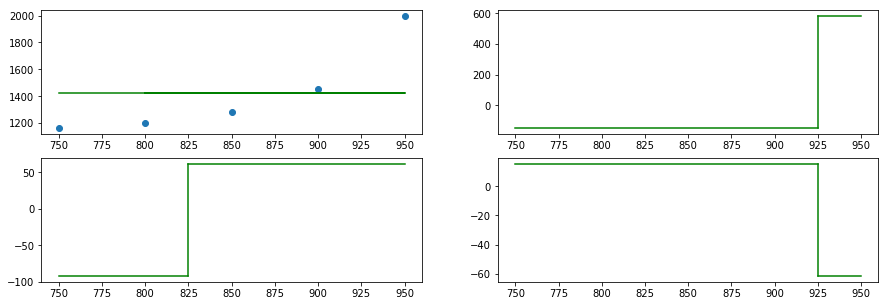

In [243]:
df = data()
X,y = df.values[:, :-1], df.values[:,-1]
bmse = BoostMse().model(X, y, 1, 3)
# bmse.printTrees()
# bmse.predict(X)

## plot F0
x, y = df.values[:, 0], df.values[:, 1]
x_sorted = x.copy()
x_sorted.sort()
X_sorted = np.sort(X, axis = 0)

fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(221)
ax.scatter(x, y)

m = len(y)
yHat = np.ones(m) * bmse.f0
ax.plot(x, yHat, c='g')

## plot F1
ax = fig.add_subplot(222)
# ax.scatter(x, y)
# yHat = bmse.predict(X_sorted, 1)
# yHat = bmse.trees[0].predict(X_sorted)
tree = bmse.trees[0]
ax.plot([x_sorted[0], tree.split_val], [tree.lmean, tree.lmean], c='g')
ax.plot([tree.split_val, tree.split_val], [tree.lmean, tree.rmean], c='g')
ax.plot([tree.split_val, x_sorted[-1]], [tree.rmean, tree.rmean], c='g')


## plot F2
ax = fig.add_subplot(223)
# ax.scatter(x, y)
# yHat = bmse.predict(X_sorted, 1)
# yHat = bmse.trees[0].predict(X_sorted)
tree = bmse.trees[1]
ax.plot([x_sorted[0], tree.split_val], [tree.lmean, tree.lmean], c='g')
ax.plot([tree.split_val, tree.split_val], [tree.lmean, tree.rmean], c='g')
ax.plot([tree.split_val, x_sorted[-1]], [tree.rmean, tree.rmean], c='g')

## plot F3
ax = fig.add_subplot(224)
# ax.scatter(x, y)
# yHat = bmse.predict(X_sorted, 1)
# yHat = bmse.trees[0].predict(X_sorted)
tree = bmse.trees[2]
ax.plot([x_sorted[0], tree.split_val], [tree.lmean, tree.lmean], c='g')
ax.plot([tree.split_val, tree.split_val], [tree.lmean, tree.rmean], c='g')
ax.plot([tree.split_val, x_sorted[-1]], [tree.rmean, tree.rmean], c='g')

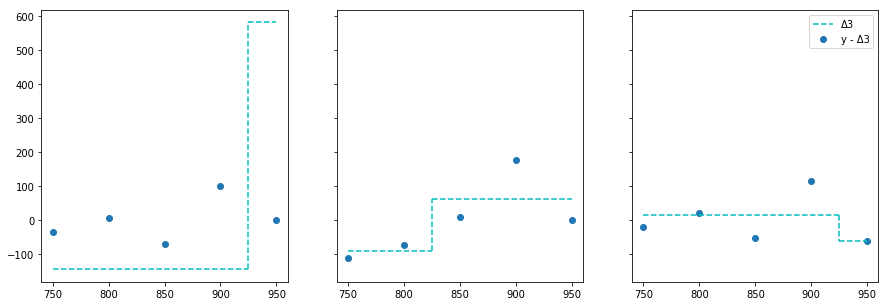

In [261]:
# 把三根基学习器画在同个图，共享 y 轴
df = data()
X,y = df.values[:, :-1], df.values[:,-1]
bmse = BoostMse().model(X, y, 1, 3)


x, y = df.values[:, 0], df.values[:, 1]
sorted_idx = np.argsort(x)
x_sorted = x[sorted_idx]
y = y[sorted_idx]
X_sorted = np.sort(X, axis = 0)

fig, ax = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=True, figsize=(15, 5))

for i in range(3):
    ## plot Fi
    tree = bmse.trees[i]
    ax[i].scatter(x_sorted, y - bmse.predict(X_sorted, i), label='y - Δ' + str(i + 1))
    ax[i].plot([x_sorted[0], tree.split_val], [tree.lmean, tree.lmean], 'c--', label='Δ' + str(i + 1))
    ax[i].plot([tree.split_val, tree.split_val], [tree.lmean, tree.rmean], 'c--')
    ax[i].plot([tree.split_val, x_sorted[-1]], [tree.rmean, tree.rmean], 'c--')
plt.legend()
